In [41]:
%%capture
%pip install neo4j pandas tqdm matplotlib networkx re py2neo

In [42]:
import pandas as pd
from tqdm import tqdm
from neo4j import GraphDatabase
import re
class CompanyGraphDB:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
        print("✅ Connected to Neo4j")

    def close(self):
        self.driver.close()
        print("🔌 Connection closed")

    def clear_database(self):
        with self.driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")
            print("🧹 Cleared entire graph")

    def ingest_from_csv(self, csv_path, preview_rows=None):
        df = pd.read_csv(csv_path)
        df.columns = [
                    re.sub(r'[^a-zA-Z0-9_]', '', col.strip().lower().replace(" ", "_"))
                    for col in df.columns
                    ]      
         
        df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

        if preview_rows:
            df = df.head(preview_rows)

        with self.driver.session() as session:
            for _, row in tqdm(df.iterrows(), total=len(df), desc="🚀 Ingesting Companies"):
                row = row.where(pd.notnull(row), None)
                company_data = row.to_dict()

                # Company node
                session.run("""
                MERGE (c:Company {name: $company_name})
                SET c += $props
                """, {"company_name": row["company_name"], "props": company_data})

                # Funding node
                session.run("""
                MERGE (f:Funding {company: $company_name})
                SET f.total_funding_inr = $total_funding_raised_inr,
                    f.num_rounds = $number_of_funding_rounds,
                    f.latest_round = $latest_funding_round_type,
                    f.latest_funding_date = $latest_funding_date
                WITH f
                MATCH (c:Company {name: $company_name})
                MERGE (c)-[:HAS_FUNDING]->(f)
                """, row.to_dict() | {"company_name": row["company_name"]})

                # Relationships
                self._create_list_relationships(session, row, "investors", "Investor", "INVESTED_IN", {"type": "Company"})
                self._create_list_relationships(session, row, "tech_stack", "Tech", "USES_TECH")
                self._create_list_relationships(session, row, "competitors", "Company", "HAS_COMPETITOR")
                self._create_list_relationships(session, row, "major_customers", "Customer", "SERVES_CUSTOMER")

                for role in ["founder", "board_member"]:
                    self._create_list_relationships(session, row, role, "Person", f"{role.upper()}_OF")

                # Hiring status
                session.run("""
                MERGE (h:HiringStatus {company: $company_name})
                SET h.status = $hiring_status,
                    h.popular_roles = $popular_roles_open
                WITH h
                MATCH (c:Company {name: $company_name})
                MERGE (c)-[:HAS_HIRING_STATUS]->(h)
                """, row.to_dict() | {"company_name": row["company_name"]})

                # Industry
                if row.get("industry_sector"):
                    session.run("""
                    MERGE (i:Industry {name: $industry})
                    WITH i
                    MATCH (c:Company {name: $company_name})
                    MERGE (c)-[:OPERATES_IN]->(i)
                    """, {"industry": row["industry_sector"].strip().title(), "company_name": row["company_name"]})

                # City & State
                if row.get("headquarters_city"):
                    session.run("""
                    MERGE (city:City {name: $city})
                    WITH city
                    MATCH (c:Company {name: $company_name})
                    MERGE (c)-[:LOCATED_IN]->(city)
                    """, {"city": row["headquarters_city"].strip().title(), "company_name": row["company_name"]})

                if row.get("state") and row.get("headquarters_city"):
                    session.run("""
                    MERGE (state:State {name: $state})
                    WITH state
                    MATCH (city:City {name: $city})
                    MERGE (city)-[:PART_OF]->(state)
                    """, {
                        "state": row["state"].strip().title(),
                        "city": row["headquarters_city"].strip().title()
                    })

        print("✅ Graph ingestion completed.")

    def _create_list_relationships(self, session, row, column, node_label, rel_type, additional_props=None):
        if row.get(column):
            for item in str(row[column]).split(","):
                item = item.strip().title()
                if item:
                    base_props = {"type": rel_type}
                    if additional_props:
                        base_props.update(additional_props)

                    props = {
                        "name": item,
                        "company_name": row["company_name"],
                        "props": base_props  # ✅ added this line
                        }

                    session.run(f"""
                    MERGE (n:{node_label} {{name: $name}})
                    SET n += $props
                    WITH n
                    MATCH (c:Company {{name: $company_name}})
                    MERGE (n)-[:{rel_type}]->(c)
                    """, props)

In [39]:

## Usage Example:

db = CompanyGraphDB(
    uri="bolt://localhost:7687",
    username="neo4j",
    password="08Mi3009@"
)

# Optional: Clear existing data
db.clear_database()

# Ingest a sample (preview_rows optional)
csv_path = "../Data/Enriched_Indian_Startup_Dataset.csv" # Ensure this path is correct


db.ingest_from_csv(csv_path)

# Close connection
db.close()


/tmp/ipykernel_7871/1609394345.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


✅ Connected to Neo4j
🧹 Cleared entire graph


🚀 Ingesting Companies: 100%|██████████| 500/500 [00:29<00:00, 16.71it/s]

✅ Graph ingestion completed.
🔌 Connection closed


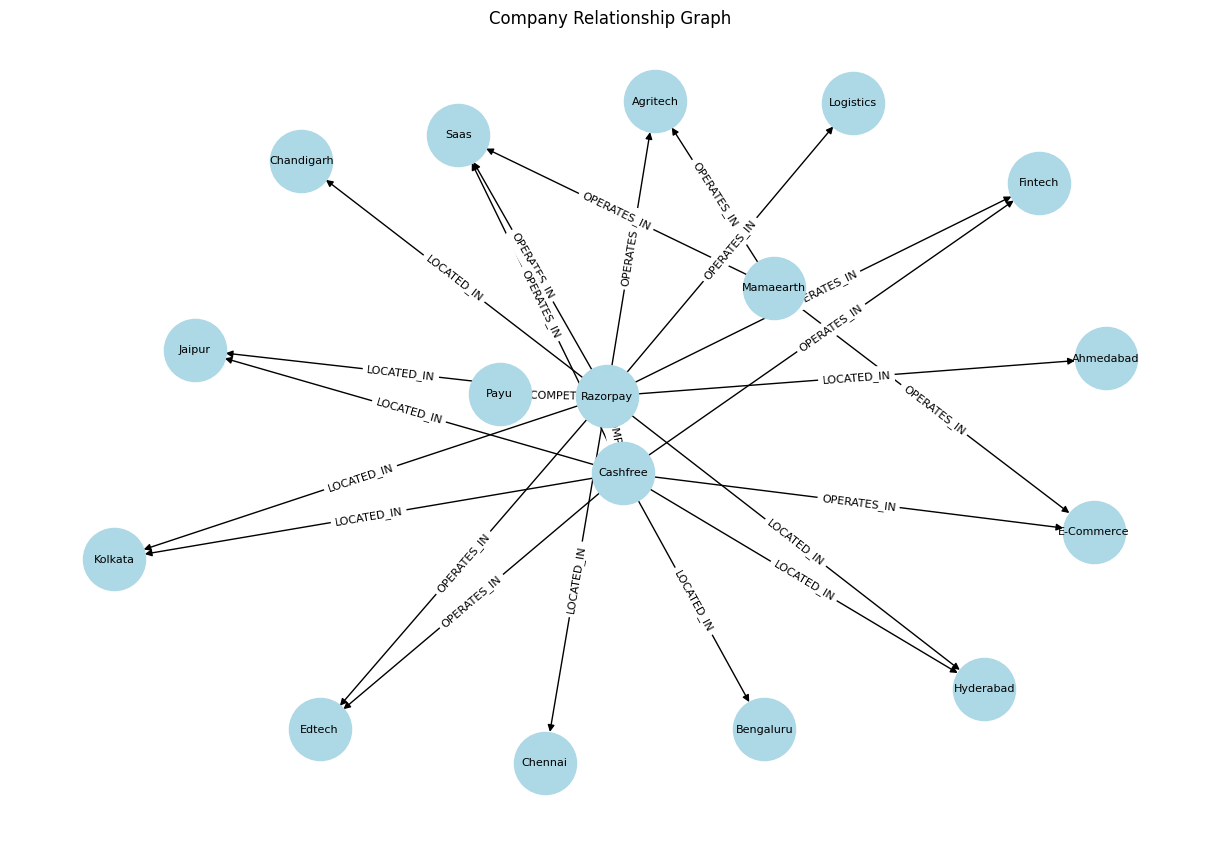

In [49]:

# Visualize the graph
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt

# Connect to local Neo4j instance
graph = Graph("bolt://localhost:7687", auth=("neo4j", "08Mi3009@"))

# Run a sample query
query = """
MATCH (c:Company)-[r]->(n)
WITH c, r, n LIMIT 30
RETURN c.name AS company, type(r) AS relation, n.name AS related
"""
results = graph.run(query).data()

# Convert to graph
G = nx.DiGraph()
for record in results:
    if record['related'] is not None:  # Filter out records where 'related' is None
        G.add_node(record['company'], label='Company')
        G.add_node(record['related'])
        G.add_edge(record['company'], record['related'], label=record['relation'])

# Plot
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=8)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Company Relationship Graph")
plt.show()


